In [5]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np
from tqdm.notebook import tqdm

# Functions:
- get_bgr_frequencies(): generates data for the histogram regarding frequencies of BGR
- get_hsi_frequencies(): generates data for the histogram regarding frequencies of HSI
- plot_rgb_freq(): plots the frequencies of the data from get_bgr_frequencies()
- plot_hsi_freq(): plots the frequencies of the data from get_hsi_frequencies()
- histo_mse(): calculates the mean squared error of 2 data inputs of bgr frequencies
- bgr_to_hsi(): converts the image from BGR to HSI
- hsi_to_bgr(): converts the image from HSI to BGR
- show_bgr_image(): show a BGR image on jupyter notebook output cell
- get_gray_scale(): generates gray scale image given a BGR image
- is_frame_close(): returns a boolean where mean of the absolute difference between input images is lower than input threshold

In [26]:
def get_bgr_frequencies(image):
    hist = {'red': [0] * 256, 'green': [0] * 256, 'blue': [0] * 256}
    for row in image:
        for pixel in row:
            hist['red'][pixel[2]] += 1
            hist['green'][pixel[1]] += 1
            hist['blue'][pixel[0]] += 1
    return hist

def get_hsi_frequencies(image):
    hist = {'hue': [0] * 360, 'saturation': [0] * 101, 'intensity': [0] * 101}
    for row in image:
        for pixel in row:
            hist['hue'][int(pixel[0])-1] += 1
            hist['saturation'][int(pixel[1] * 101)-1] += 1
            hist['intensity'][int(pixel[2] * 101)-1] += 1
    return hist

def plot_rgb_freq(freqs, save=False, save_path_name=None):
    plt.plot(freqs['red'], color='red',label='Red')
    plt.plot(freqs['green'], color='green',label='Green')
    plt.plot(freqs['blue'], color='blue',label='Blue')
    plt.show()
    if save:
        assert save_path_name is not None, "Please provide a name for the file"
        plt.savefig(save_path_name)


def plot_hsi_freq(freqs, save=False, save_path_name=None):

    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    cm_hue = plt.get_cmap('hsv')
    for i in range(256):
        ax1.bar(i, freqs['hue'][i], color=cm_hue(i/360))
    ax1.set_title('Hue')
    ax1.set_xticks(np.arange(0, 360, 18))

    for i in range(101):
        ax2.bar(i, freqs['saturation'][i], color='black')
        ax3.bar(i, freqs['intensity'][i], color='black')

    ax2.set_title('Saturation')
    ax2.set_xlabel('Saturation in 100 bins')
    ax2.set_ylabel('Frequency')

    ax3.set_title('Intensity')
    ax3.set_xlabel('Intensity in 100 bins')
    ax3.set_ylabel('Frequency')
    
    plt.show()
    if save:
        assert save_path_name is not None, "Please provide a name for the file"
        plt.savefig(save_path_name)
    plt.close()

def histo_mse(hist1, histo2):
    mse = 0
    for i in range(256):
        mse += (hist1['red'][i] - histo2['red'][i])**2
        mse += (hist1['green'][i] - histo2['green'][i])**2
        mse += (hist1['blue'][i] - histo2['blue'][i])**2
    return np.sqrt(mse)

def bgr_to_hsi(bgr_image):
    with np.errstate(divide='ignore', invalid='ignore'):
        B,G,R = np.squeeze(bgr_image[...,0]), np.squeeze(bgr_image[...,1]), np.squeeze(bgr_image[...,2])
        sum_rgb = R + G + B
        b,g,r = B/255, G/255, R/255

        I = (b + g + r) / 3
        indexes = sum_rgb != 0
        ri = r[indexes]
        gi = g[indexes]
        bi = b[indexes]

        H = np.zeros_like(I)
        H[indexes] = np.arccos(0.5 * (2*ri-gi-bi) / np.sqrt((ri-gi)**2 + (ri-bi)*(gi-bi)))
        H[(R == G) & (G == B)] = 0
        H = np.nan_to_num(H)
        bg_indexes = b>g
        H[bg_indexes] = 2*np.pi - H[bg_indexes]
        H = np.degrees(H)

        S = np.zeros_like(I)
        S[indexes] = (1 - np.minimum(np.minimum(ri,gi),bi)/I[indexes])

        return np.dstack((H,S,I))

def hsi_to_bgr(hsi_image):
    with np.errstate(divide='ignore', invalid='ignore'):
        H,S,I = np.squeeze(hsi_image[...,0]), np.squeeze(hsi_image[...,1]), np.squeeze(hsi_image[...,2])
        R,G,B = np.zeros_like(I), np.zeros_like(I), np.zeros_like(I)
        
        ind120 = H < 120
        ind240 = (H >= 120) & (H < 240)
        ind360 = H >= 240
        H = np.radians(H)
        
        B[ind120] = (I*(1-S))[ind120]
        R[ind120] = (I*(1+S*np.cos(H)/np.cos(np.pi/3-H)))[ind120]
        G[ind120] = (3*I-(R+B))[ind120]

        H[ind240] = (H-120)[ind240]
        R[ind240] = (I*(1-S))[ind240]
        G[ind240] = (I*(1+S*np.cos(H)/np.cos(np.pi/3-H)))[ind240]

        H[ind360] = (H-240)[ind360]
        G[ind360] = (I*(1-S))[ind360]
        B[ind360] = (I*(1+S*np.cos(H)/np.cos(np.pi/3-H)))[ind360]
        R[ind360] = (3*I-(G+B))[ind360]

        R,G,B = R*255, G*255, B*255
        return np.dstack((B,G,R)).astype('uint8')

def show_bgr_image(image, grayscale=False):
    if grayscale:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
def get_gray_scale(bgr_image):
    return np.dot(bgr_image[...,:3], [0.299, 0.587, 0.114])

def is_frame_close(true_frame, test_frame, avg_threshold=1):
    diff = np.abs(true_frame - test_frame)
    return np.mean(diff) < avg_threshold

In [3]:
image_o = cv2.imread('./data/WSC sample.png')
image = image_o.copy()

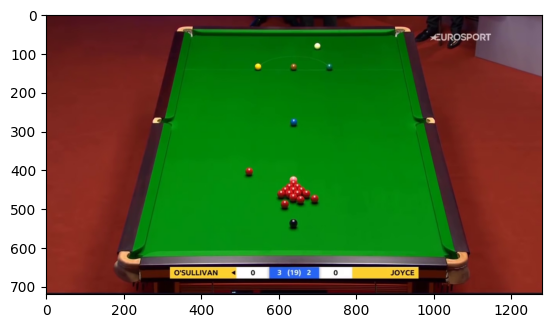

In [4]:
show_bgr_image(image)

## Conversion to HSI and plotting of frequencies regarding Hue, Saturation and Intensity

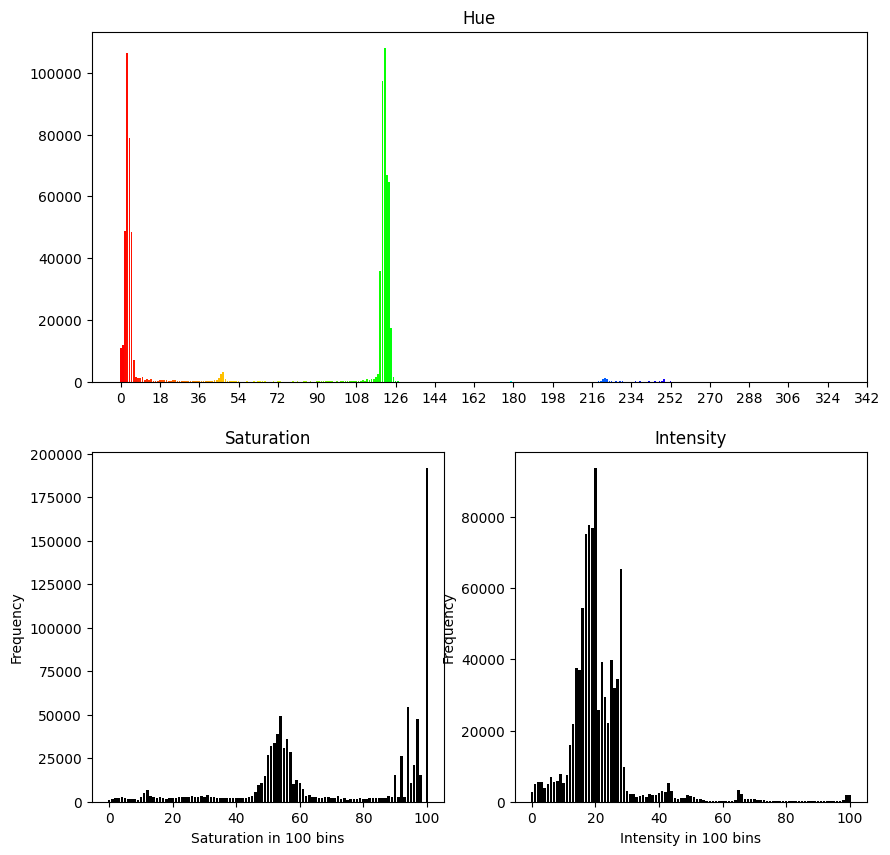

In [5]:
hsi_image = bgr_to_hsi(image)
hsi_freqs = get_hsi_frequencies(hsi_image)
plot_hsi_freq(hsi_freqs)

## We can see that the green of the table lies for some hue values between 100 and 130. So we can create a mask out of it.

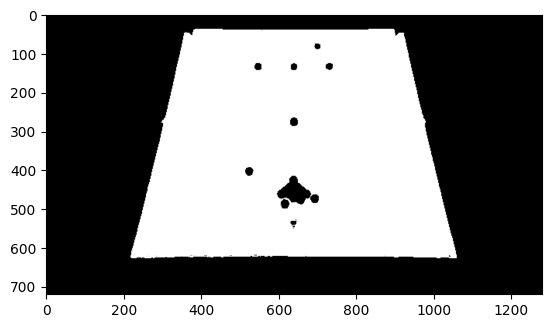

In [6]:
hue = hsi_image[...,0]
table = (hue > 100) & (hue < 130)
filtered = np.zeros_like(image)
filtered[table] = [255,255,255]
show_bgr_image(filtered)

## First frame of the video

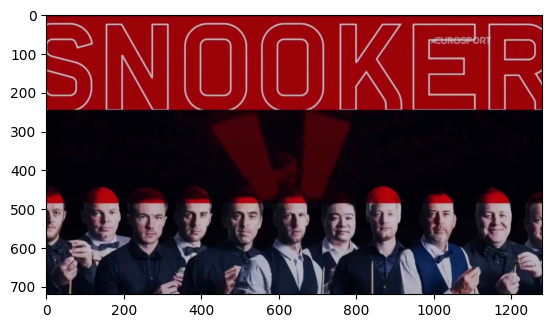

In [6]:
first_frame = cv2.imread('./data/first frame.png')
show_bgr_image(first_frame)

## Testing if the functions to see if first frame and masked sample frame have a big difference (which they should)

In [7]:
first_frame = cv2.imread('./data/first frame.png')
first_frame_filtered =first_frame.copy()
first_frame_filtered[~table] = [0,0,0]
image_filtered = image.copy()
image_filtered[~table] = [0,0,0]
is_frame_close(image_filtered, first_frame_filtered)

False

## Getting some stats about the video

In [20]:
video = cv2.VideoCapture('./data/WSC.mp4')
frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
frame_rate = video.get(cv2.CAP_PROP_FPS)
video_duration = frame_count / frame_rate
print(f"The video duration is {video_duration} seconds.")
# convert to hour, minutes seconds
video_duration = int(video_duration)
hours = video_duration // 3600
minutes = (video_duration % 3600) // 60
seconds = video_duration % 60
print(f"The video duration is {hours} hours, {minutes} minutes and {seconds} seconds.")
video.release()

The video duration is 12262.6 seconds.
The video duration is 3 hours, 24 minutes and 22 seconds.


## This timestamps were taken by obervation of the video, to compute analyze some thresholds and decide the value to which we should filter the video. Images are saved with the respective error in printed into it

In [7]:
interesting_frames_timestaps = {
    0: {'hour': 0, 'minute': 16, 'second': 56 },
    1: {'hour': 0, 'minute': 17, 'second': 31 },
    2: {'hour': 0, 'minute': 28, 'second': 40 },
    3: {'hour': 0, 'minute': 29, 'second': 8 },
    4: {'hour': 0, 'minute': 29, 'second': 39 },
    5: {'hour': 0, 'minute': 29, 'second': 42 },
    6: {'hour': 0, 'minute': 59, 'second': 18 },
    7: {'hour': 2, 'minute': 51, 'second': 40 },
    8: {'hour': 2, 'minute': 39, 'second': 27 }   
}

for i, timestamp in interesting_frames_timestaps.items():
    video.set(cv2.CAP_PROP_POS_MSEC, (timestamp['hour']*3600 + timestamp['minute']*60 + timestamp['second'])*1000)
    ret, frame = video.read()
    cv2.imwrite(f'./data/interesting_frame_{i}.png', frame)

In [24]:
dist = {}
for i in range(9):
    test_frame = cv2.imread(f'./data/interesting_frame_{i}.png')
    test_frame[~table] = [0,0,0]
    dist[i] = is_frame_close(get_gray_scale(image_filtered), get_gray_scale(test_frame))
    cv2.putText(test_frame, f"Error: {dist[i]}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.imwrite(f'./data/interesting_frame_{i}_filtered.png', test_frame)
print(dist)

{0: 1.3067543891059021, 1: 0.860668962673611, 2: 2.775466866319445, 3: 0.5904960394965278, 4: 14.85328125, 5: 1.787783945312501, 6: 4.9686758387586805, 7: 4.020196752387152, 8: 8.860475402560764}


## A good threshold seems to be 1.0, hence we filter the whole video using our mask the that difference threshold

In [8]:
video = cv2.VideoCapture('./data/WSC.mp4')
frame_width = int(video.get(3))
frame_height = int(video.get(4))
fps = video.get(cv2.CAP_PROP_FPS)
out = cv2.VideoWriter('./data/WSC_filtered.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
true_table = ~table
filtered_gray_image = get_gray_scale(image_filtered)
frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)


for i in tqdm(range(int(frame_count))):
    ret, frame = video.read()
    if ret:
        test_frame = frame.copy()
        test_frame[true_table] = [0,0,0]
        test_frame = get_gray_scale(test_frame)
        if is_frame_close(filtered_gray_image, test_frame, avg_threshold=1):
            out.write(frame)
    else:
        break
    
video.release()
out.release()

  0%|          | 0/367878 [00:00<?, ?it/s]

## Standard bgr to hsi conversion and back to hsi, for testing purposes.

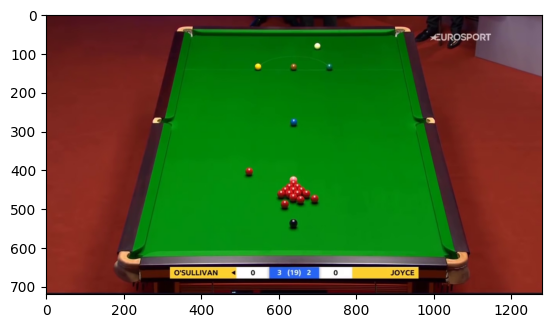

In [57]:
show_bgr_image(image)

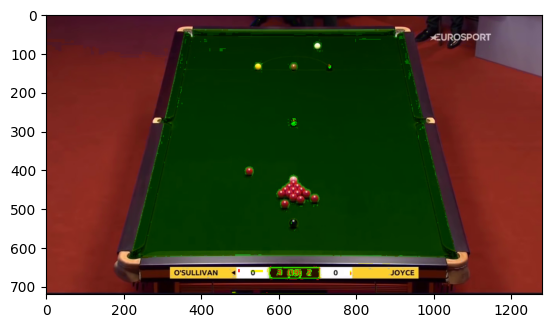

In [108]:
show_bgr_image(hsi_to_bgr(bgr_to_hsi(image)))

## Getting the frame suggested in the slides, in timestamp 2:11:52, and saving it.

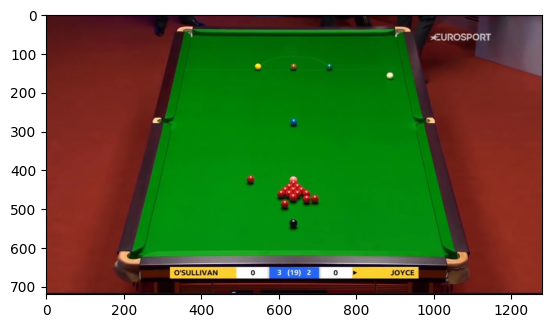

In [38]:
video = cv2.VideoCapture('./data/WSC.mp4')
video.set(cv2.CAP_PROP_POS_MSEC, (2*3600 + 11*60 + 52)*1000)
ret, frame = video.read()
cv2.imwrite(f'./data/balls_in_position.png', frame)
show_bgr_image(frame)

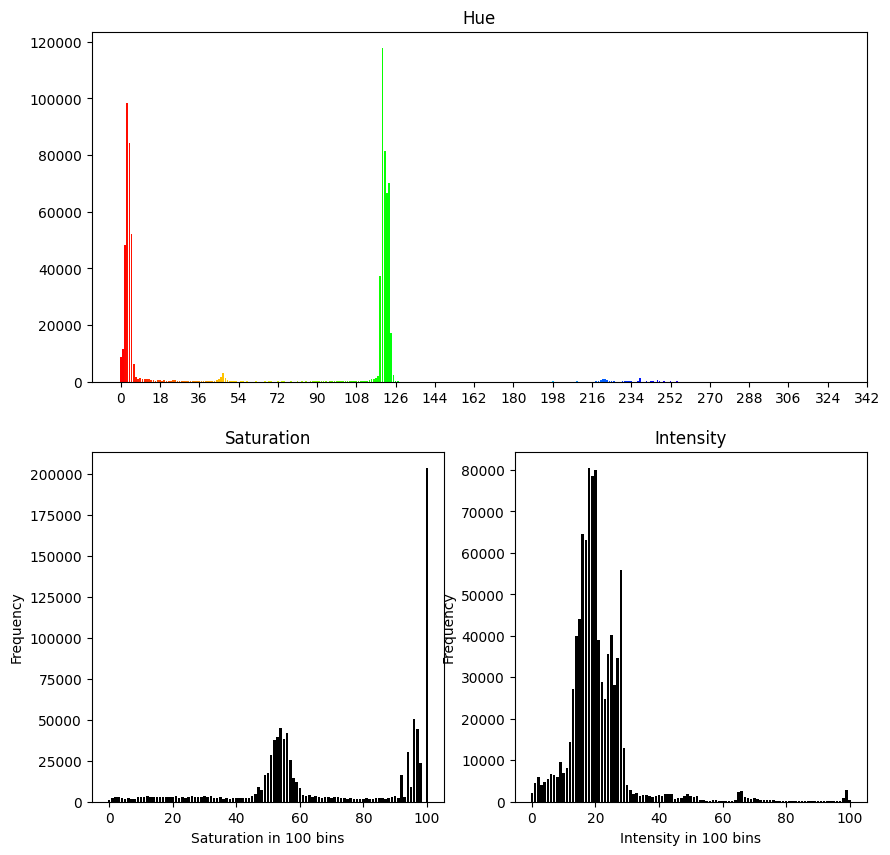

In [8]:
hsi_frame = bgr_to_hsi(frame)
hsi_frame_hist = get_hsi_frequencies(hsi_frame)
plot_hsi_freq(hsi_frame_hist)

In [14]:
gray_scale_image = get_gray_scale(frame)
gray_scale_image.shape

(720, 1280)

## Implementation

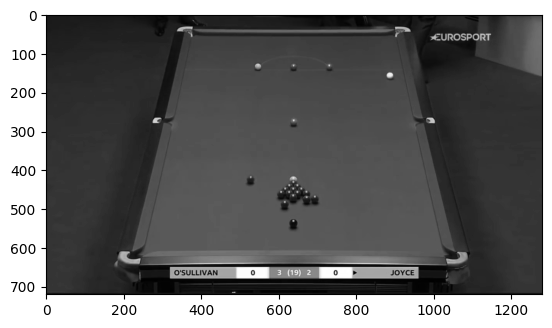

In [41]:
import math

def apply_gaussian_filter(img, sigma=1, a=1):
    M, N = img.shape
    b = a
    m = 2*a+1
    n = 2*b+1

    sigma = 1
    g = np.zeros((m))
    for s in range(-a,a+1):
        g[s+a] = math.exp(-s*s/2/(sigma*sigma))
    c = g/np.sum(g)
    r = c

    A1 = np.copy(img)
    for i in range(0,M):
        for j in range(0,N):
            I = 0
            for s in range(-a,a+1):
                if (i+s < 0):
                    I = I + c[s+a] * img[0,j]
                elif (i+s > M-1):
                    I = I + c[s+a] * img[M-1,j]
                else:
                    I = I + c[s+a] * img[i+s,j]
            A1[i,j] = round(I)

    B1 = np.copy(A1)
    for i in range(0,M):
        for j in range(0,N):
            I = 0
            for t in range(-b,b+1):
                if (j+t < 0):
                    I = I + r[t+b] * A1[i,0]
                elif (j+t > N-1):
                    I = I + r[t+b] * A1[i,N-1]
                else:
                    I = I + r[t+b] * A1[i,j+t]
            B1[i,j] = round(I)
            
    return B1

gray_scale_image = get_gray_scale(frame)
show_bgr_image(gray_scale_image, grayscale=True)

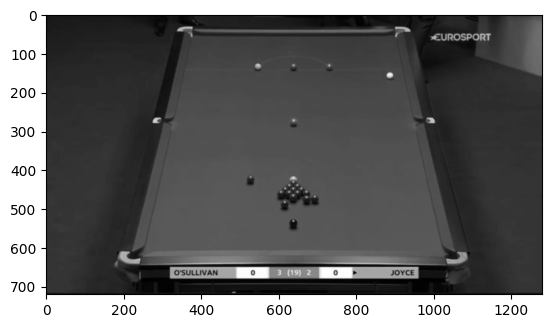

In [24]:
show_bgr_image(apply_gaussian_filter(gray_scale_image, sigma=100, a=30), grayscale=True)

In [72]:
from scipy.ndimage import convolve

def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

def hysteresis(img, weak, strong=255):
    M, N = img.shape

    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i, j] == weak):
                if (
                    (img[i+1, j-1] == strong) or (img[i+1, j] == strong) or
                    (img[i+1, j+1] == strong) or (img[i, j-1] == strong) or
                    (img[i, j+1] == strong) or (img[i-1, j-1] == strong) or
                    (img[i-1, j] == strong) or (img[i-1, j+1] == strong)
                ):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img

def sobel_operate(image):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = convolve(image, Kx)
    Iy = convolve(image, Ky)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255

    theta = np.arctan2(Iy, Ix)

    return G, theta

def non_max_suppression(G, theta):
    M,N = G.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
            q = 255
            r = 255
            
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                r = G[i, j-1]
                q = G[i, j+1]

            elif (22.5 <= angle[i,j] < 67.5):
                r = G[i-1, j+1]
                q = G[i+1, j-1]

            elif (67.5 <= angle[i,j] < 112.5):
                r = G[i-1, j]
                q = G[i+1, j]

            elif (112.5 <= angle[i,j] < 157.5):
                r = G[i+1, j+1]
                q = G[i-1, j-1]

            if (G[i,j] >= q) and (G[i,j] >= r):
                Z[i,j] = G[i,j]
            else:
                Z[i,j] = 0
    return Z


def canny_edge_detection(img, sigma=1, a=1, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    gray_scale_img = get_gray_scale(img)
    gray_scale_img = apply_gaussian_filter(gray_scale_image, sigma, a)
    G, theta = sobel_operate(gray_scale_img)
    Z = non_max_suppression(G, theta)
    (res, weak, strong) = threshold(Z, lowThresholdRatio, highThresholdRatio)
    img_final = hysteresis(res, weak, strong)
    return img_final



In [105]:
sigma=10
a=10
lowThresholdRatio=0.05
highThresholdRatio=0.09
img = frame

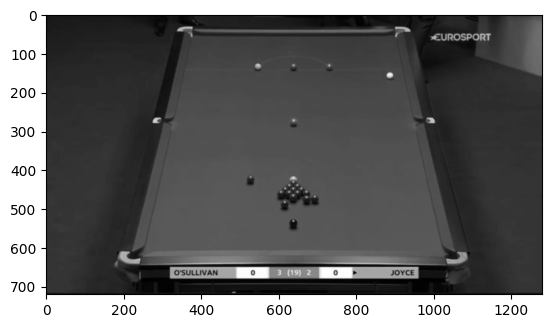

In [106]:
gray_scale_img = get_gray_scale(img)
gray_scale_img = apply_gaussian_filter(gray_scale_image, sigma, a)
show_bgr_image(gray_scale_img, grayscale=True)

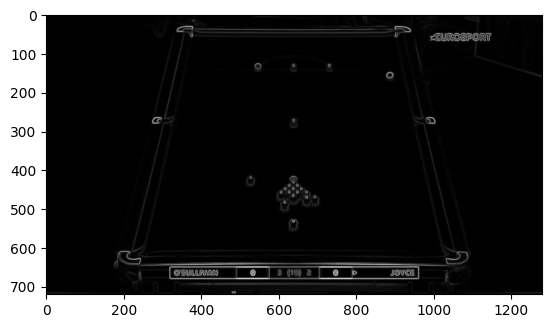

In [107]:
G, theta = sobel_operate(gray_scale_img)
show_bgr_image(G, grayscale=True)

In [108]:
Z = non_max_suppression(G, theta)

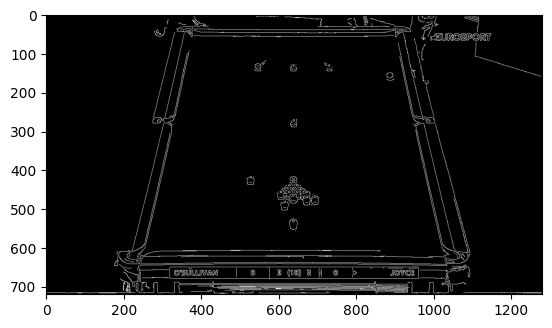

In [111]:
(res, weak, strong) = threshold(Z, 0.01, 0.036)
img_final = hysteresis(res, weak, strong)
show_bgr_image(img_final, grayscale=True)

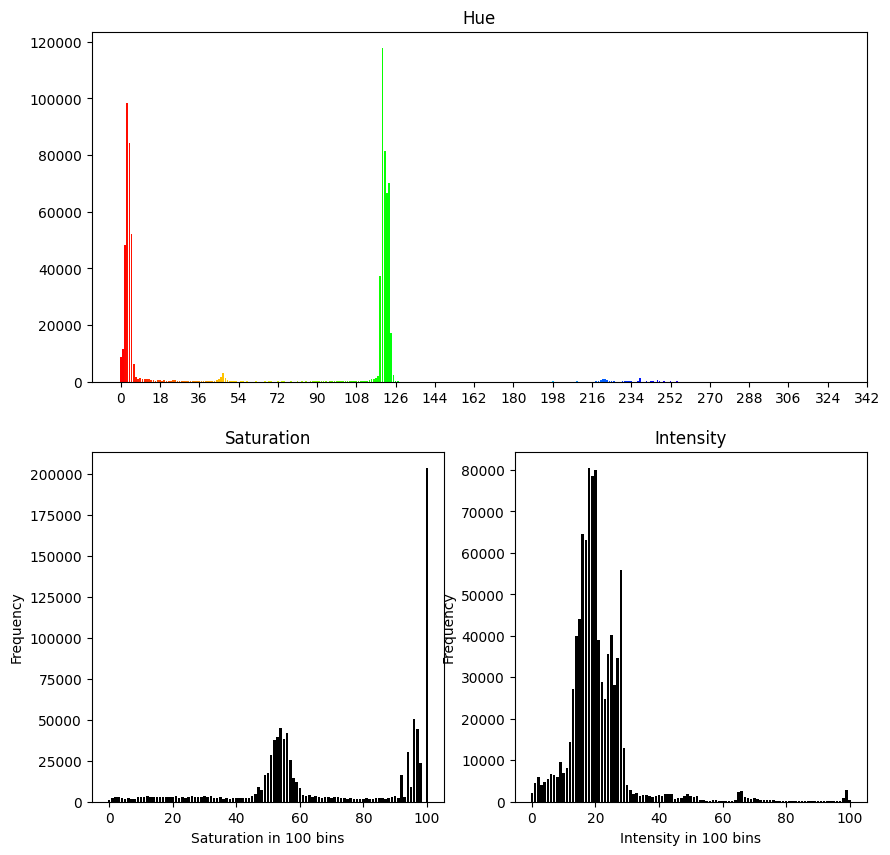

In [120]:
frame = cv2.imread('./data/balls_in_position.png')
hsi_frame = bgr_to_hsi(frame)
hsi_frame_freqs = get_hsi_frequencies(hsi_frame)
plot_hsi_freq(hsi_frame_freqs)

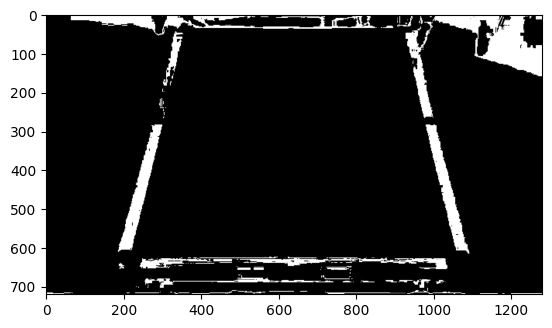

In [144]:
hue = hsi_frame[...,0]
table = (hue > 310) & (hue < 350)
filtered = np.zeros_like(frame)
filtered[table] = [255,255,255]
show_bgr_image(filtered)

In [146]:
sigma=10
a=10
lowThresholdRatio=0.05
highThresholdRatio=0.09

In [150]:
filtered.shape

(720, 1280, 3)

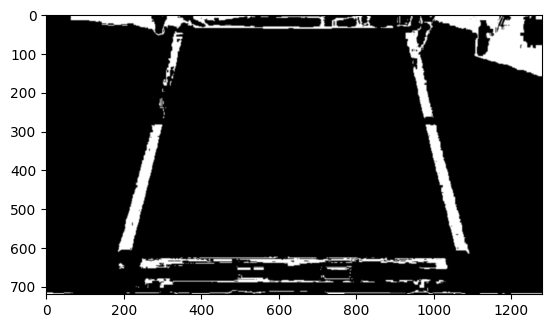

In [151]:
gray_scale_img = apply_gaussian_filter(filtered[...,0], sigma, a)
show_bgr_image(gray_scale_img, grayscale=True)

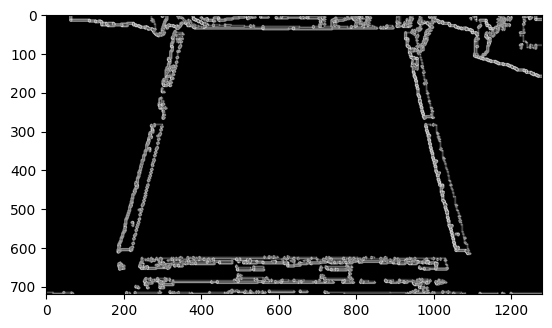

In [152]:
G, theta = sobel_operate(gray_scale_img)
show_bgr_image(G, grayscale=True)

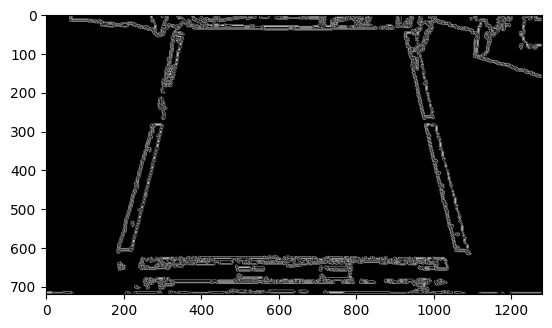

In [153]:
Z = non_max_suppression(G, theta)
(res, weak, strong) = threshold(Z, 0.01, 0.036)
img_final = hysteresis(res, weak, strong)
show_bgr_image(img_final, grayscale=True)